In [61]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt
from gensim.matutils import any2sparse
from gensim.models import LdaModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [63]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [64]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_documents, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [65]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_tweets[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

$DNN picked some up, like this going into 2014
...and here is its corresponding label 

2


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [66]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [67]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_tweets)
X_train = vectorizer.transform(train_tweets)
X_val = vectorizer.transform(val_documents)
X_test_tweets = vectorizer.transform(test_tweets)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['peroni', 'and', 'grolsch', 'put', 'up', 'for', 'sale', 'a', 'ab', 'inbev']


In [68]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10754


              precision    recall  f1-score   support

           0       0.73      0.44      0.55        50
           1       0.64      0.29      0.40        31
           2       0.66      0.92      0.77        97

    accuracy                           0.67       178
   macro avg       0.68      0.55      0.57       178
weighted avg       0.68      0.67      0.64       178



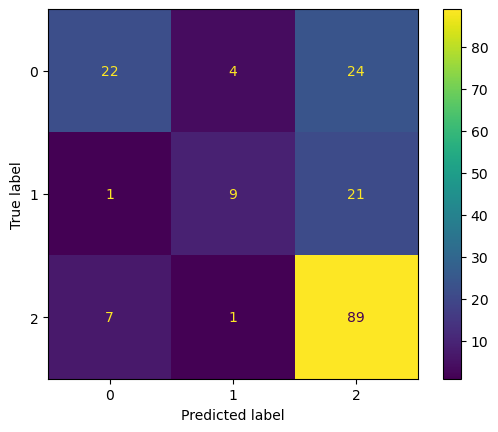

In [69]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [70]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [71]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_tweets.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_tweets.multiply(lexicon_neg_scores), axis=1)

In [72]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_tweets = hstack((X_test_tweets, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.74      0.46      0.57        50
           1       0.64      0.29      0.40        31
           2       0.67      0.92      0.77        97

    accuracy                           0.68       178
   macro avg       0.68      0.56      0.58       178
weighted avg       0.69      0.68      0.65       178



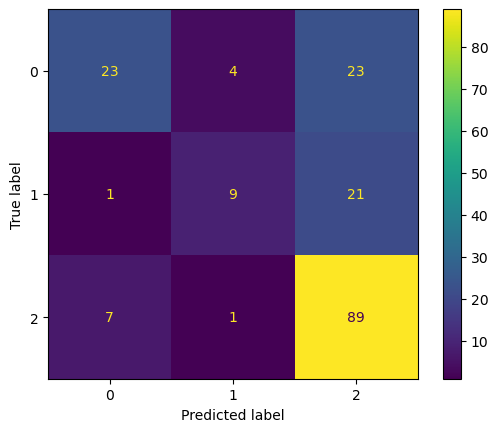

In [73]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [74]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: UPDATE 1-Lloyds to cut 945 jobs as part of 3-year restructuring plan; true label = 0, prediction = 1.
Tweet: $AAPL at pivot area on intraday chart- break here could send this to 50-day SMA, 457.80 http://stks.co/jPbN; true label = 1, prediction = 2.
Tweet: $RNN More bleeding Monday.; true label = 0, prediction = 2.
Tweet: UPDATE 5-Barclays Chairman McFarlane axes CEO to speed up strategic change; true label = 0, prediction = 1.
Tweet: Sanofi poaches AstraZeneca scientist as new research head; true label = 1, prediction = 2.
Tweet: CompaniesDiageo stays neutral on India boardroom turmoil; true label = 1, prediction = 2.
Tweet: $HZNP havent seen vol like this since the runup. lets see one more dip to 2.0x; true label = 0, prediction = 2.
Tweet: 4 beaten-down Internet companies that may be ripe for a #takeover target: #Twitter $TWTR - #LinkedIn $LNKD - #Yahoo! $YHOO - #Groupon $GRPN; true label = 1, prediction = 2.
Tweet: $SLW is down, but weekly $34 calls (-28.95%), .23 x .25 have

# Performance on test set

              precision    recall  f1-score   support

           0       0.67      0.56      0.61        62
           1       0.86      0.15      0.26        39
           2       0.68      0.91      0.78       122

    accuracy                           0.68       223
   macro avg       0.74      0.54      0.55       223
weighted avg       0.71      0.68      0.64       223



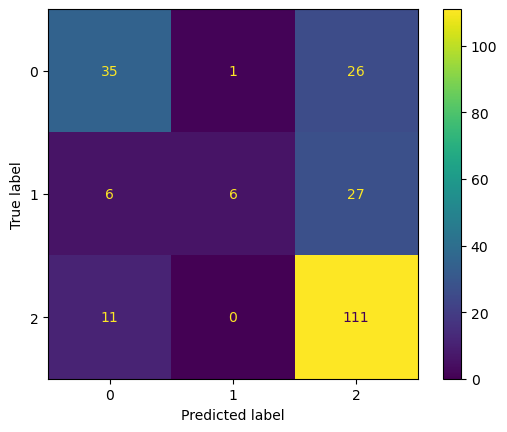

In [75]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_tweets)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [76]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_tweets)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [77]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_tweets:
    processed.append(preprocess(doc))
print(processed)

[['prlb', 'hang', 'tough', 'market', 'analyst', 'upgrade', 'week'], ['skx', 'turn', 'come', 'far', 'far', 'stock', 'price', 'imply', 'pay', 'business'], ['ftse', 'edge', 'investors', 'cheer', 'kingfisher', 'result'], ['ab', 'inbev', 'sell', 'sabmiller', 'stake', 'china', 'snow', 'beer'], ['britain', 'ftse', 'get', 'lift', 'prudential', 'result'], ['rt', 'andrewnyquist', 'chartology', 'yahoo', 'http', 'stks', 'itr', 'yhoo', 'crazy', 'look', 'chart', 'near', 'breakout', 'resistance', 'line'], ['uk', 'winners', 'losers', 'aviva', 'friends', 'life', 'lead', 'ftse', 'gainers'], ['aapl', 'test', 'high', 'today', 'probably', 'hours'], ['nuan', 'hold', 'big', 'gain', 'maybe', 'finally', 'undervalue', 'major', 'upside'], ['aapl', 'bounce', 'support'], ['rt', 'dasan', 'tmtanalyst', 'aapl', 'master', 'supply', 'chain', 'corner', 'nand', 'apple', 'master', 'supply', 'chain'], ['rbi', 'surprise', 'street', 'sensex', 'par', 'gain', 'hit', 'mount'], ['fb', 'dax', 'say', 'bye', 'bye', 'finish', 'great

In [78]:
from gensim.corpora import Dictionary
# create a dictionary of word:id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2279 unique tokens: ['analyst', 'hang', 'market', 'prlb', 'tough']...)


In [79]:
# Getting means of thetas and training the LDA.



lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(tweets, lda_model):
    thetas = []
    for i in range(len(tweets)):
        # Get the tweet
        unseen_tweet = tweets[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(val_tweets, lda_model)

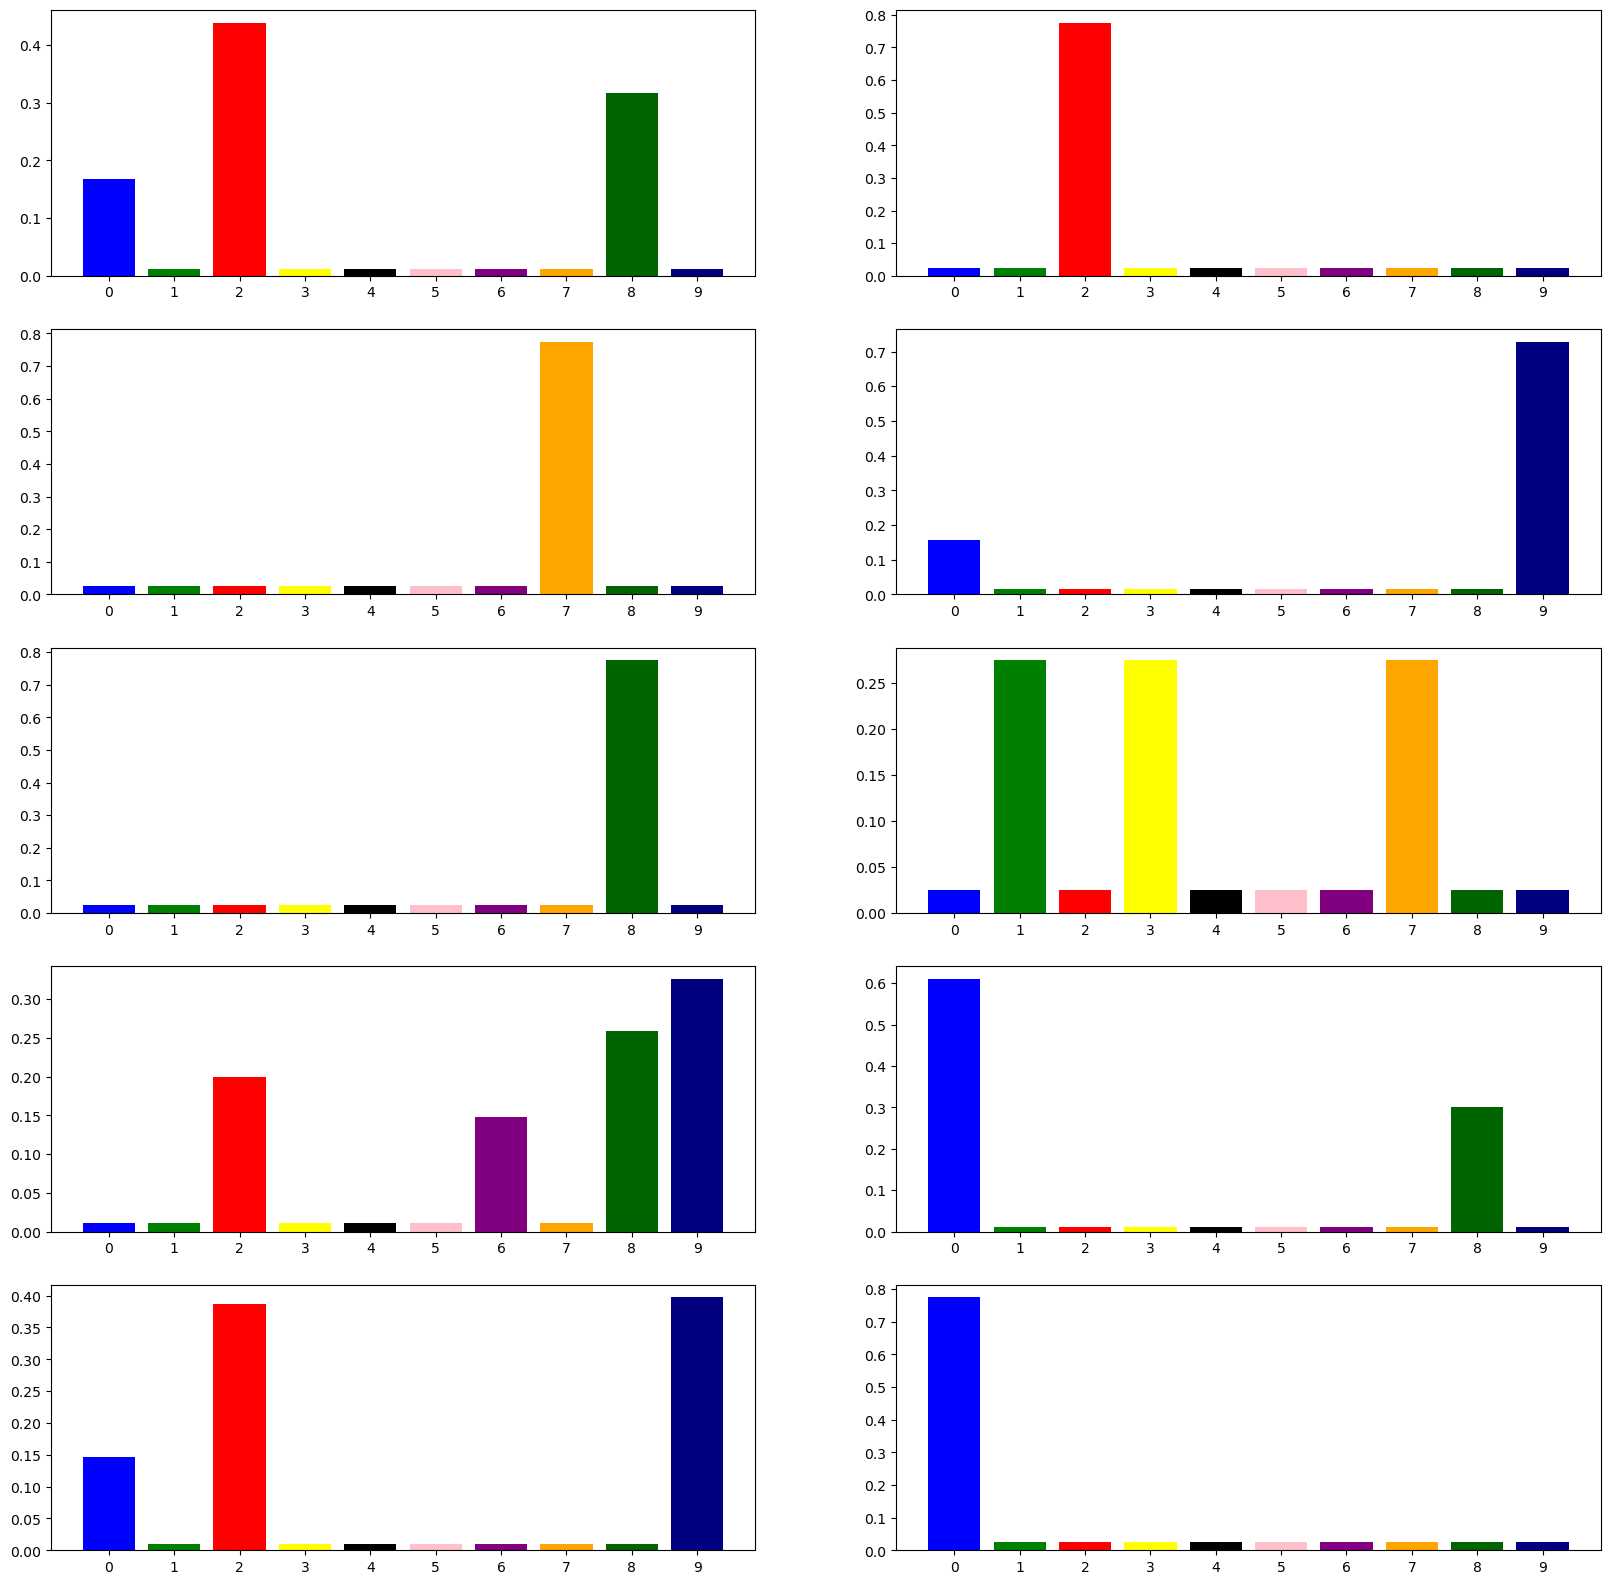

In [80]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))

plt.figure(figsize=(20,20))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

# Visualizing topic distributions across labels using validation set

In [81]:
# Merge arrays for later 
arr = val_tweets
arr_2 = val_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['CEOs of BPM, UBI meet Italy econ minister as M&A talk heats up' '1']
 ['$PLUG Closed short position. Small gain. Not interested in options expiring worthless'
  '1']
 ['Phew! So far good $BBRY did not break 10.40 coz I was told that is key support level.'
  '1']
 ['Philip Morris, BAT Sue Over Law Taking Branding Off Packs' '1']
 ['Entertainment One dispels ITV takeover rumours' '1']
 ["RT @jan $ARNA Don't think buyout rumor strong enough too be driving this up just yet...when it is this may fly like aapl...// fly how high?"
  '1']
 ["Should you buy Associated British Foods plc, Great Portland Estates plc and Dunelm Group plc following today's news?"
  '1']
 ['RBS will reportedly appoint Howard Davies as its next chairman' '1']
 ["$AAPL Now I'm glad I got stopped out of my $113 weeklies when I did. Will re-enter next Monday for the #earnings run-up."
  '1']
 ['After Barclays and Bank of America, Citigroup has blockchain in sight'
  '1']
 ["Insight hires Aviva's David Hillier for mult

In [82]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(val_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.07421321 0.08899906 0.14060884 0.14719202 0.06499586 0.05653861
 0.09236617 0.03789192 0.16672457 0.1252339 ]
[0.07510735 0.16560152 0.17384562 0.06162812 0.05228343 0.14164295
 0.08978386 0.08864429 0.05847686 0.08477165]
[0.08941226 0.07653736 0.16110814 0.13167627 0.06799861 0.04878669
 0.0924079  0.09602186 0.0837922  0.14722387]
(3, 10)


[0.0743579  0.08899226 0.12936482 0.15029732 0.06602553 0.0478039
 0.09936742 0.04175427 0.17078179 0.12601893]
[0.07313373 0.14945691 0.16776964 0.06624739 0.05227899 0.14163217
 0.0899352  0.08864594 0.05618021 0.10650547]
[0.09616459 0.07908945 0.15461166 0.13355006 0.06899126 0.04878351
 0.08984932 0.09602702 0.0818056  0.14609268]


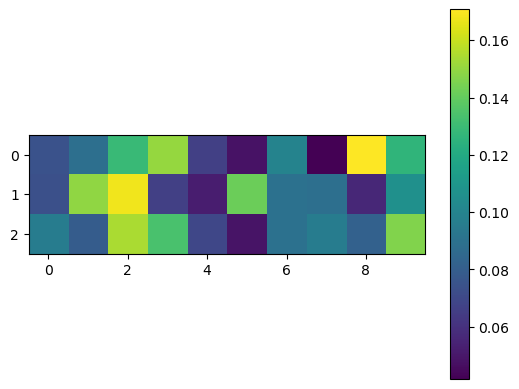

In [83]:
def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()

In [84]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.014*"stks" + 0.013*"http" + 0.011*"today" + 0.011*"buy" + 0.010*"standard" + 0.010*"https" + 0.009*"charter" + 0.009*"watch" + 0.008*"fb" + 0.007*"bank"


Topic ID: 1 
Associated Words:
 0.016*"https" + 0.013*"share" + 0.012*"profit" + 0.009*"rise" + 0.008*"dividend" + 0.008*"amzn" + 0.007*"break" + 0.007*"price" + 0.007*"look" + 0.007*"astrazeneca"


Topic ID: 2 
Associated Words:
 0.023*"plc" + 0.023*"stks" + 0.023*"http" + 0.017*"long" + 0.014*"https" + 0.011*"breakout" + 0.009*"stock" + 0.008*"fb" + 0.008*"price" + 0.007*"share"


Topic ID: 3 
Associated Words:
 0.011*"price" + 0.009*"buy" + 0.009*"http" + 0.009*"stks" + 0.009*"ftse" + 0.008*"https" + 0.007*"aapl" + 0.007*"spy" + 0.007*"group" + 0.006*"share"


Topic ID: 4 
Associated Words:
 0.014*"buy" + 0.011*"shire" + 0.010*"look" + 0.010*"close" + 0.010*"short" + 0.010*"long" + 0.008*"deal" + 0.008*"baxalta" + 0.007*"fb" + 0.006*"aapl"


Topic ID: 5 
Associated Words:
 0.010*"https" + 0.006*"b

# Using test set

[['$PAY 2nd time test of the 21.20-30 b/o zone.  Still not breaking out.  Moved my stop up to 20.80.'
  '1']
 ['UPDATE 1-Engineering firm Smiths Group confirms CEO appointment' '1']
 ['Apple: Another attempt to break out on Apple but with weak PVT   $AAPL #Trading #investing #aapl https://t.co/DNh7Hgv22V'
  '1']
 ['Ocwen Reaches Settlement With California Regulator' '1']
 ['Whats up with $LULU?  Numbers looked good, not great, but good.  I think conference call will instill confidence.'
  '1']
 ['$AGN and $PYPL under pressure along with the market, however there were bullish options trades in both this morning https://t.co/9xG5W8nONT'
  '1']
 ["Whitbread boss Andy Harrison defends sales fall as 'just a blip'" '1']
 ['ConAgra Names Former Hillshire Farms CEO Connolly to Top Post' '1']
 ['$GILD Sandbagged the guidance so the can use that last 3 billion up.  CC was cautiously optimistic, wait til Next ER for confirmation'
  '1']
 ['$MA http://stks.co/1CYN continues to consolidate / base h

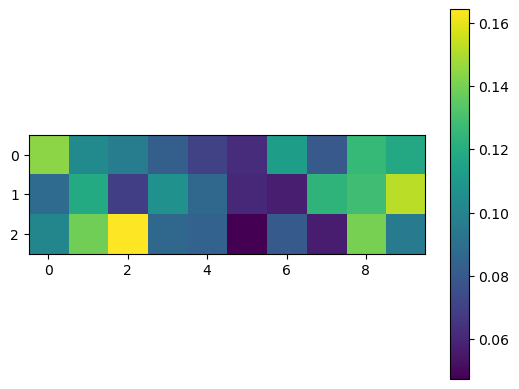

In [85]:
# Merge arrays for later 
arr = test_tweets
arr_2 = test_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(test_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()